Visualisation & Analysis from Schellart et al, 2010
======

This notebook visualises a three-dimensional 7,000 km wide subducting plate as shown in Figure S3c of [Schelart et al, 2010](http://science.sciencemag.org/content/329/5989/316).

**References**
1. Schellart, W. P. and Stegman, D. R. and Farrington, R. J. and Freeman, J. and Moresi, L. Cenozoic Tectonics of Western North America Controlled by Evolving Width of Farallon Slab. Science, 16 July 2010, Vol. 329, Issue 5989, pp. 316-319 [Schelart et al, 2010](http://science.sciencemag.org/content/329/5989/316).

In [1]:
import underworld as uw
uw.matplotlib_inline()
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
import matplotlib.pyplot as pyplot
import h5py
import glob


In [2]:
inputPath = os.path.join(os.path.abspath("."),"output/")

** The swarms aren't being advected!! run it again :( **


In [3]:
# use low resolution if running in serial
# use xRes = 96 to produce Fig 3b of OzBench (2008)
yRes = 8  # 48 in paper
xRes = yRes*3
zRes = yRes*3  
dim  = 3
boxLength = 7.0
boxHeight = 1.0
boxWidth  = 7.0 

**Create mesh and finite element variables**

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes, zRes), 
                                 minCoord    = (0., 0., 0.), 
                                 maxCoord    = (boxLength, boxHeight, boxWidth)) 

velocityField  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField  = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

Load velocity and pressure field

In [5]:
# load mesh, velocity & pressure fields via checkpoint files
step = 2
velocityField.load(inputPath+'velocityField.'+ str(step).zfill(5) +'.h5') 

In [6]:
pressureField.load(inputPath+'pressureField.'+ str(step).zfill(5) +'.h5') 

In [7]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( velocityField.fn_gradient ))

**Create the particle swarm**

In [8]:
swarm         = uw.swarm.Swarm( mesh=mesh )
trenchSwarm   = uw.swarm.Swarm( mesh=mesh )
slab1Swarm    = uw.swarm.Swarm( mesh=mesh )
slab2Swarm    = uw.swarm.Swarm( mesh=mesh )
slab3Swarm    = uw.swarm.Swarm( mesh=mesh )

materialIndex = swarm.add_variable( dataType="int", count=1 )

Load swarm files

In [9]:
# load swarm, materialVariable and viscosityVariable from checkpoint
swarm.load(         inputPath +'swarm.'        + str(step).zfill(5) +'.h5')  

In [10]:
materialIndex.load( inputPath +'materialIndex.'+ str(step).zfill(5) +'.h5')

In [11]:
trenchSwarm.load(   inputPath +'trenchSwarm.'  + str(step).zfill(5) +'.h5')  

In [12]:
slab1Swarm.load(    inputPath +'slab1Swarm.'   + str(step).zfill(5) +'.h5')  

In [13]:
slab2Swarm.load(    inputPath +'slab2Swarm.'   + str(step).zfill(5) +'.h5')  

In [14]:
slab3Swarm.load(    inputPath +'slab3Swarm.'   + str(step).zfill(5) +'.h5')  

In [15]:
# initialise the 'materialVariable' data to represent two different materials. 
upperMantleIndex = 0
lowerMantleIndex = 1
upperSlabIndex   = 2
core1SlabIndex   = 3
core2SlabIndex   = 4
lowerSlabIndex   = 5

** Visualise subducting slab with strain rate invariant**

In [16]:
#Project material index on to mesh for use in plotting material isosurfaces
materialField     = uw.mesh.MeshVariable( mesh, 1 )
materialProjector = uw.utils.MeshVariable_Projection( materialField, materialIndex, type=0 )
materialProjector.solve()


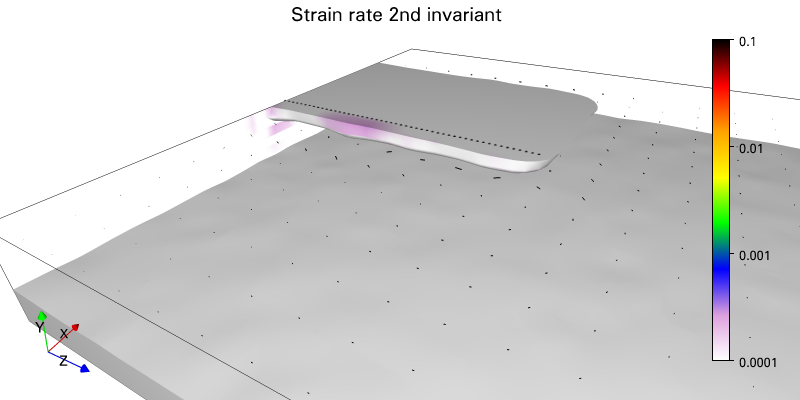

In [17]:
# set up visualisation of slab isosurface with strain rate.
figMaterialStrain = glucifer.Figure( figsize=(800,400), title="Strain rate 2nd invariant", 
                                    facecolour='white', quality=3, axis=True)

#When plotting an isosurface, a second function can be passed to colour the surface
surf = figMaterialStrain.IsoSurface( mesh, materialField, strainRate_2ndInvariant, logScale=True,
                                     isovalues=[0.5], isowalls=True, valueRange=[0.0001, 0.1], 
                                     colours='White Plum Blue Green Yellow Orange Red Black')

surf.colourBar["position"] = 0.0
surf.colourBar["size"] = [0.8,0.02]
surf.colourBar["tickvalues"] = [0.0001, 0.001, 0.01, 0.1]
surf.colourBar["align"] = "right"

figMaterialStrain.append(surf)



#Cross sections at the boundaries, use the same colour map as isosurface
figMaterialStrain.append(glucifer.objects.Surface( mesh, strainRate_2ndInvariant, crossSection="x 100%", 
                          colourMap=surf.colourMap, colourBar=False, valueRange=[0.0001, 0.1]))
figMaterialStrain.append(glucifer.objects.Surface( mesh, strainRate_2ndInvariant, crossSection="z 0%",   
                          colourMap=surf.colourMap, colourBar=False, valueRange=[0.0001, 0.1]))

# plot tracer particles
figMaterialStrain.append(glucifer.objects.Points(trenchSwarm, colourBar=False, pointSize=2 ))
# plot velocity vectors
figMaterialStrain.append(glucifer.objects.VectorArrows(mesh, velocityField*2e3, 
                                                       autoscale=False, resolution=[16,2,16]))

#Apply the camera script
camera = ['rotate y 60', 'rotate x 30', 'zoom 3.0', 'translate x 1.5']
sc = figMaterialStrain.script(camera)

figMaterialStrain.show()